<a href="https://colab.research.google.com/github/pplateena/MMPAI-NULP/blob/main/l1_MMPAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

#1.	Обрати публічний датасет (наприклад, для класифікації чи регресії з Kaggle або UCI Machine Learning Repository).
Я обрав датасет https://www.kaggle.com/datasets/yasserh/titanic-dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2.	Виконати Exploratory Data Analysis (EDA): візуалізація розподілу ознак, матриці кореляцій, виявлення аномалій.

In [3]:
# 3.1 Базова статистика
print("\n--- Базова статистика ---")
print(df.describe())

# 3.2 Інформація про типи даних та пропущені значення
print("\n--- Інформація про дані ---")
print(df.info())



--- Базова статистика ---
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

--- Інформація про дані ---
<class 'pandas.core.frame

## Опис змінних датасету Titanic

| Змінна | Опис | Значення |
|--------|------|----------|
| **survival** | Виживання | 0 = Ні, 1 = Так |
| **pclass** | Клас квитка | 1 = 1-й клас, 2 = 2-й клас, 3 = 3-й клас |
| **sex** | Стать | male/female |
| **age** | Вік | Вік у роках |
| **sibsp** | Кількість братів/сестер/подружжя на борту | Числове значення |
| **parch** | Кількість батьків/дітей на борту | Числове значення |
| **ticket** | Номер квитка | Текстовий/числовий ідентифікатор |
| **fare** | Тариф пасажира | Числове значення (ціна квитка) |
| **cabin** | Номер каюти | Текстовий ідентифікатор |
| **embarked** | Порт посадки | C = Шербур, Q = Квінстаун, S = Саутгемптон |

In [4]:
print("\n--- Пропущені значення ---")
missing_values = df.isnull().sum()
print("Кількість пропущених значень по стовпцям:")
for col, missing in missing_values.items():
    if missing > 0:
        percentage = (missing / len(df)) * 100
        print(f"  {col}: {missing} ({percentage:.1f}%)")


--- Пропущені значення ---
Кількість пропущених значень по стовпцям:
  Age: 177 (19.9%)
  Cabin: 687 (77.1%)
  Embarked: 2 (0.2%)


Проміжні висновки:
* немає даних 19,9% по віку вагомої кількості пасажирів(*Важливо*)
* немає 77,1% даних по кабінах пасажирів, цю змінну швидше за все прийдеться упустити(*Не важливо*)
* пропущено 0.2% значень по порту посадки пасажирів(*Не важливо*)

In [5]:
# Розподіл цільової змінної (виживання)
print("\n--- Розподіл цільової змінної (Survived) ---")
survival_counts = df['Survived'].value_counts()
print(f"Загинули (0): {survival_counts[0]} ({survival_counts[0]/len(df)*100:.1f}%)")
print(f"Вижили (1): {survival_counts[1]} ({survival_counts[1]/len(df)*100:.1f}%)")


--- Розподіл цільової змінної (Survived) ---
Загинули (0): 549 (61.6%)
Вижили (1): 342 (38.4%)


Проміжні висновки:
* Розподіл target variable, майже рівний, це хороший знак, прийдеться робити мінімум змін при розподілі даних у майбутньому


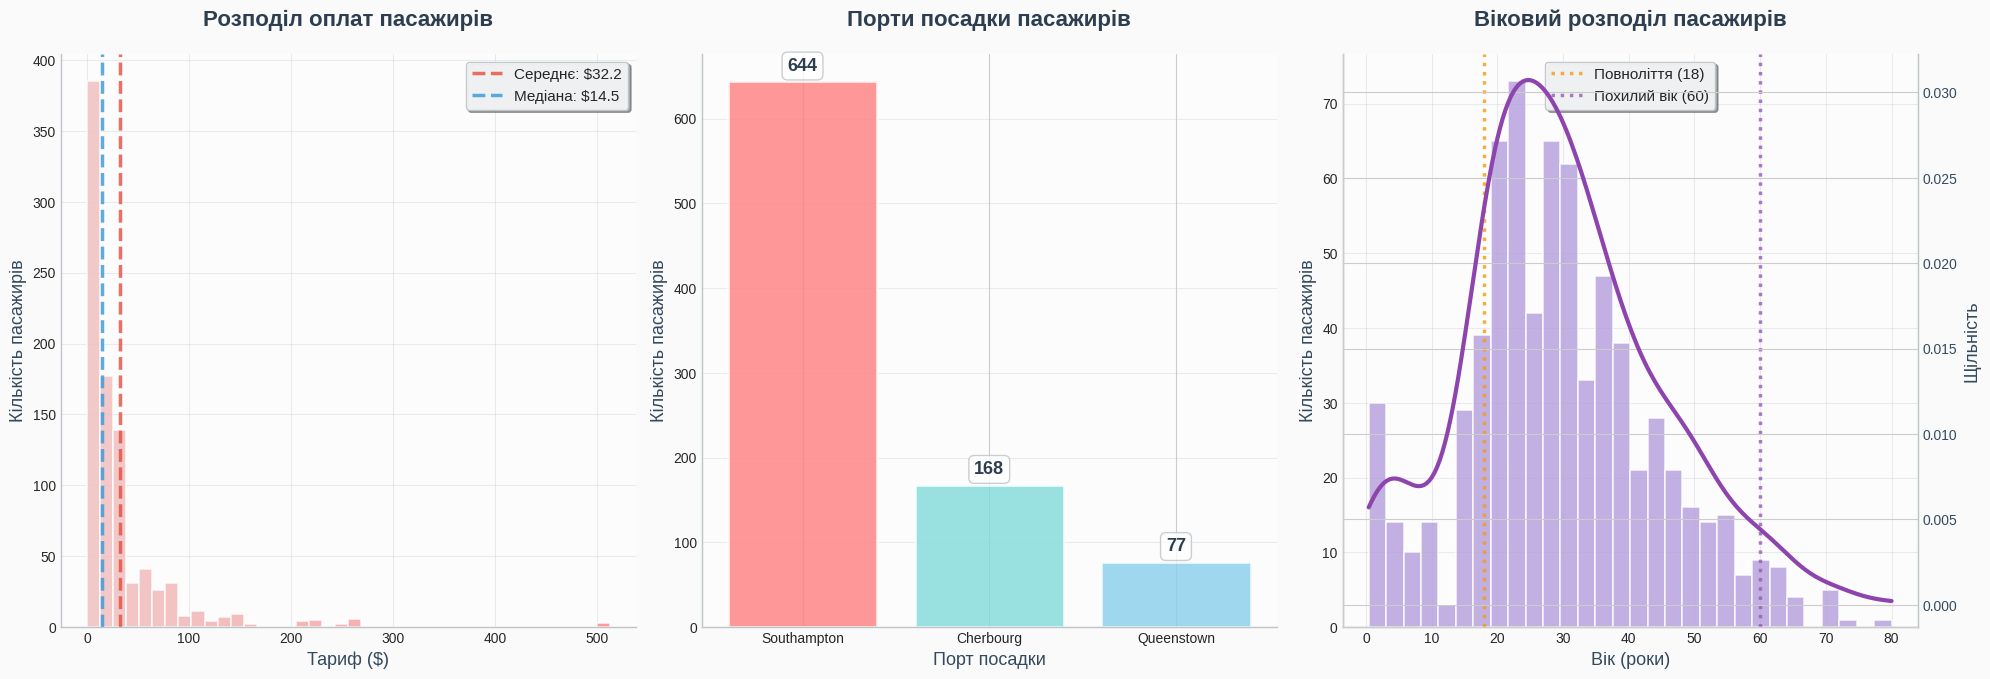

In [6]:
# Налаштування стилю
plt.style.use('seaborn-v0_8-whitegrid')

# Організовані кольори
COLORS = {
    # Основні кольори для графіків
    'coral': '#FF7F7F',
    'mint': '#7FDBDA',
    'sky': '#87CEEB',
    'lavender': '#B39DDB',

    # Статистичні лінії
    'mean_line': '#E74C3C',
    'median_line': '#3498DB',
    'age_adult': '#F39C12',
    'age_senior': '#9B59B6',
    'kde_curve': '#8E44AD',

    # Фонові кольори
    'bg_main': '#FAFAFA',
    'bg_plot': '#FCFCFC',
    'grid': '#BDC3C7',
    'text_main': '#2C3E50',
    'text_secondary': '#34495E',
    'legend_bg': '#F8F9FA'
}

# Створення графіків
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.patch.set_facecolor(COLORS['bg_main'])

# 1. Розподіл оплат
axes[0].set_facecolor(COLORS['bg_plot'])
n, bins, patches = axes[0].hist(df['Fare'], bins=40, alpha=0.8, edgecolor='white', linewidth=1.2)

base_color = np.array([1.0, 0.5, 0.5])
for i, patch in enumerate(patches):
    intensity = 0.4 + 0.6 * (i / len(patches))
    color = base_color * intensity + (1 - intensity) * 0.9
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

axes[0].set_title('Розподіл оплат пасажирів', fontsize=16, fontweight='600',
                  color=COLORS['text_main'], pad=20)
axes[0].set_xlabel('Тариф ($)', fontsize=13, color=COLORS['text_secondary'], fontweight='500')
axes[0].set_ylabel('Кількість пасажирів', fontsize=13, color=COLORS['text_secondary'], fontweight='500')

mean_fare = df['Fare'].mean()
median_fare = df['Fare'].median()
axes[0].axvline(mean_fare, color=COLORS['mean_line'], linestyle='--', linewidth=2.5,
                label=f'Середнє: ${mean_fare:.1f}', alpha=0.8)
axes[0].axvline(median_fare, color=COLORS['median_line'], linestyle='--', linewidth=2.5,
                label=f'Медіана: ${median_fare:.1f}', alpha=0.8)

legend = axes[0].legend(fontsize=11, frameon=True, shadow=True, fancybox=True, framealpha=0.9)
legend.get_frame().set_facecolor(COLORS['legend_bg'])
legend.get_frame().set_edgecolor(COLORS['grid'])

axes[0].grid(True, alpha=0.3, color=COLORS['grid'], linestyle='-', linewidth=0.8)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_color(COLORS['grid'])
axes[0].spines['bottom'].set_color(COLORS['grid'])

# 2. Порти посадки
axes[1].set_facecolor(COLORS['bg_plot'])
embarked_counts = df['Embarked'].value_counts()
port_names = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}
nice_names = [port_names.get(port, port) for port in embarked_counts.index]

bars = axes[1].bar(nice_names, embarked_counts.values,
                   color=[COLORS['coral'], COLORS['mint'], COLORS['sky']],
                   alpha=0.8, edgecolor='white', linewidth=2)

for bar, value in zip(bars, embarked_counts.values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 8,
                f'{value}', ha='center', va='bottom', fontsize=13,
                color=COLORS['text_main'], fontweight='600',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor=COLORS['grid']))

axes[1].set_title('Порти посадки пасажирів', fontsize=16, fontweight='600',
                  color=COLORS['text_main'], pad=20)
axes[1].set_xlabel('Порт посадки', fontsize=13, color=COLORS['text_secondary'], fontweight='500')
axes[1].set_ylabel('Кількість пасажирів', fontsize=13, color=COLORS['text_secondary'], fontweight='500')

axes[1].grid(True, alpha=0.3, color=COLORS['grid'], axis='y', linestyle='-', linewidth=0.8)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_color(COLORS['grid'])
axes[1].spines['bottom'].set_color(COLORS['grid'])

# 3. Віковий розподіл
axes[2].set_facecolor(COLORS['bg_plot'])
axes[2].hist(df['Age'].dropna(), bins=30, alpha=0.8,
             color=COLORS['lavender'], edgecolor='white', linewidth=1.2)


age_data = df['Age'].dropna()
density = stats.gaussian_kde(age_data)
x_range = np.linspace(age_data.min(), age_data.max(), 200)

ax2_twin = axes[2].twinx()
ax2_twin.plot(x_range, density(x_range), color=COLORS['kde_curve'], linewidth=3)
ax2_twin.set_ylabel('Щільність', fontsize=13, color=COLORS['text_secondary'], fontweight='500')
ax2_twin.tick_params(colors=COLORS['text_secondary'])
ax2_twin.spines['right'].set_color(COLORS['grid'])
ax2_twin.spines['top'].set_visible(False)

axes[2].set_title('Віковий розподіл пасажирів', fontsize=16, fontweight='600',
                  color=COLORS['text_main'], pad=20)
axes[2].set_xlabel('Вік (роки)', fontsize=13, color=COLORS['text_secondary'], fontweight='500')
axes[2].set_ylabel('Кількість пасажирів', fontsize=13, color=COLORS['text_secondary'], fontweight='500')

axes[2].axvline(18, color=COLORS['age_adult'], linestyle=':', linewidth=2.5,
                label='Повноліття (18)', alpha=0.8)
axes[2].axvline(60, color=COLORS['age_senior'], linestyle=':', linewidth=2.5,
                label='Похилий вік (60)', alpha=0.8)

legend2 = axes[2].legend(fontsize=11, frameon=True, shadow=True, fancybox=True, framealpha=0.9)
legend2.get_frame().set_facecolor(COLORS['legend_bg'])
legend2.get_frame().set_edgecolor(COLORS['grid'])

axes[2].grid(True, alpha=0.3, color=COLORS['grid'], linestyle='-', linewidth=0.8)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].spines['left'].set_color(COLORS['grid'])
axes[2].spines['bottom'].set_color(COLORS['grid'])

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

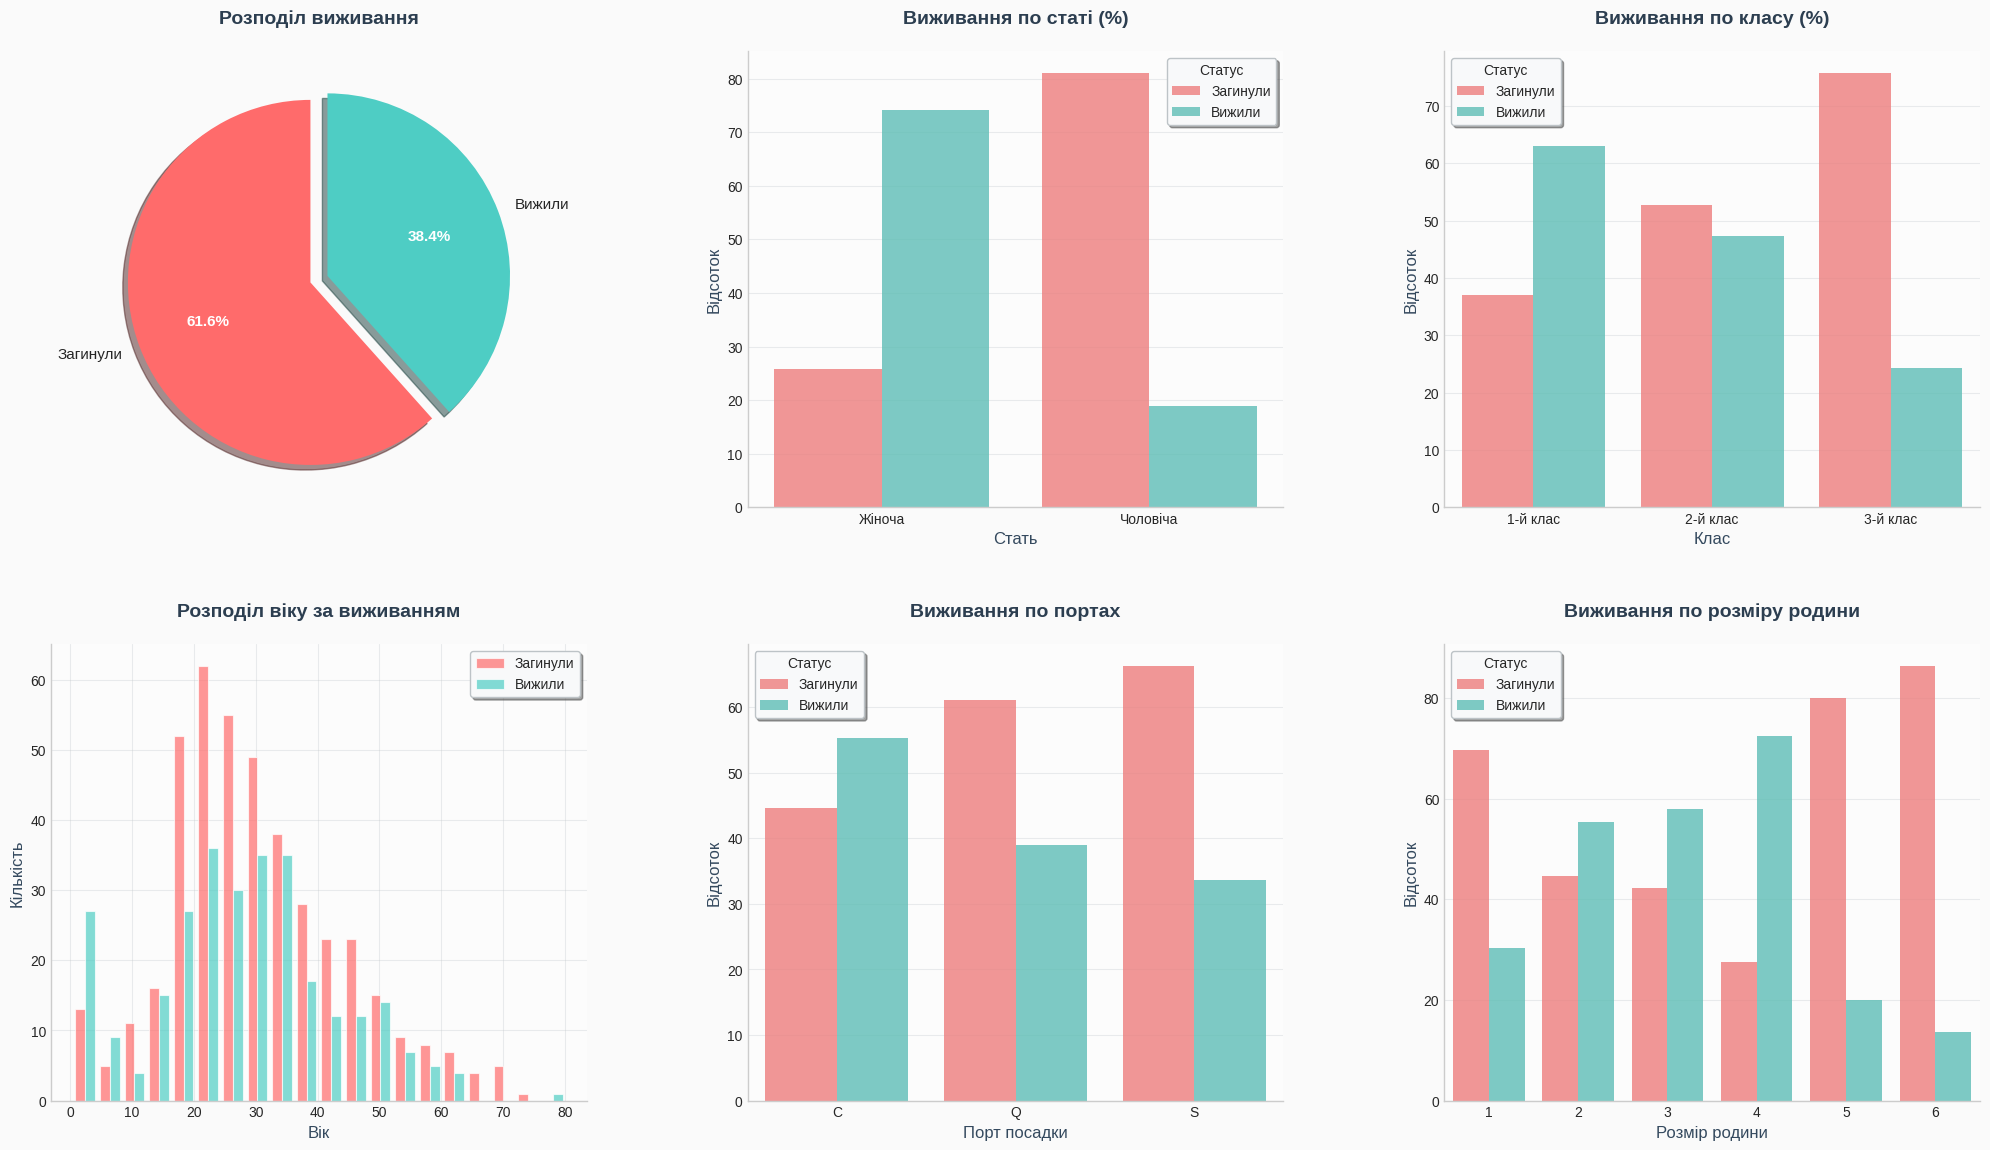

In [7]:
# Налаштування стилю
plt.style.use('seaborn-v0_8-whitegrid')

# Кольори для графіків виживання
SURVIVAL_COLORS = {
    'died': '#FF6B6B',          # Червоний для загиблих
    'survived': '#4ECDC4',      # Бірюзовий для тих що вижили
    'bg_main': '#FAFAFA',
    'bg_plot': '#FCFCFC',
    'grid': '#BDC3C7',
    'text_main': '#2C3E50',
    'text_secondary': '#34495E',
    'legend_bg': '#F8F9FA'
}

# Підготовка даних
survival_counts = df['Survived'].value_counts()

# Створення графіків 2x3 (як в оригінальному коді)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.patch.set_facecolor(SURVIVAL_COLORS['bg_main'])
# fig.suptitle('Аналіз виживання пасажирів Титаніка',
#              fontsize=20, fontweight='600', color=SURVIVAL_COLORS['text_main'], y=0.95)

# 1. Pie chart розподілу виживання
axes[0,0].set_facecolor(SURVIVAL_COLORS['bg_plot'])
wedges, texts, autotexts = axes[0,0].pie(survival_counts.values,
                                         labels=['Загинули', 'Вижили'],
                                         autopct='%1.1f%%',
                                         colors=[SURVIVAL_COLORS['died'], SURVIVAL_COLORS['survived']],
                                         startangle=90,
                                         explode=(0.05, 0.05),
                                         shadow=True,
                                         textprops={'fontsize': 11, 'fontweight': '500'})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

axes[0,0].set_title('Розподіл виживання', fontsize=14, fontweight='600',
                    color=SURVIVAL_COLORS['text_main'], pad=20)

# 2. Виживання по статі (bar chart)
axes[0,1].set_facecolor(SURVIVAL_COLORS['bg_plot'])
survival_by_sex = pd.crosstab(df['Sex'], df['Survived'], normalize='index') * 100

# Використовуємо seaborn для красивого bar plot
sex_data = survival_by_sex.reset_index().melt(id_vars='Sex', var_name='Survived', value_name='Percentage')
sex_data['Status'] = sex_data['Survived'].map({0: 'Загинули', 1: 'Вижили'})

sns.barplot(data=sex_data, x='Sex', y='Percentage', hue='Status', ax=axes[0,1],
            palette=[SURVIVAL_COLORS['died'], SURVIVAL_COLORS['survived']], alpha=0.8)

axes[0,1].set_title('Виживання по статі (%)', fontsize=14, fontweight='600',
                    color=SURVIVAL_COLORS['text_main'], pad=20)
axes[0,1].set_xlabel('Стать', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])
axes[0,1].set_ylabel('Відсоток', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])
axes[0,1].set_xticklabels(['Жіноча', 'Чоловіча'])

legend1 = axes[0,1].legend(title='Статус', fontsize=10, frameon=True, shadow=True)
legend1.get_frame().set_facecolor(SURVIVAL_COLORS['legend_bg'])
legend1.get_frame().set_edgecolor(SURVIVAL_COLORS['grid'])

axes[0,1].grid(True, alpha=0.3, color=SURVIVAL_COLORS['grid'], axis='y')
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['right'].set_visible(False)

# 3. Виживання по класу (bar chart)
axes[0,2].set_facecolor(SURVIVAL_COLORS['bg_plot'])
survival_by_class = pd.crosstab(df['Pclass'], df['Survived'], normalize='index') * 100

# Підготовка даних для seaborn
class_data = survival_by_class.reset_index().melt(id_vars='Pclass', var_name='Survived', value_name='Percentage')
class_data['Status'] = class_data['Survived'].map({0: 'Загинули', 1: 'Вижили'})

sns.barplot(data=class_data, x='Pclass', y='Percentage', hue='Status', ax=axes[0,2],
            palette=[SURVIVAL_COLORS['died'], SURVIVAL_COLORS['survived']], alpha=0.8)

axes[0,2].set_title('Виживання по класу (%)', fontsize=14, fontweight='600',
                    color=SURVIVAL_COLORS['text_main'], pad=20)
axes[0,2].set_xlabel('Клас', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])
axes[0,2].set_ylabel('Відсоток', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])
axes[0,2].set_xticklabels(['1-й клас', '2-й клас', '3-й клас'])

legend2 = axes[0,2].legend(title='Статус', fontsize=10, frameon=True, shadow=True)
legend2.get_frame().set_facecolor(SURVIVAL_COLORS['legend_bg'])
legend2.get_frame().set_edgecolor(SURVIVAL_COLORS['grid'])

axes[0,2].grid(True, alpha=0.3, color=SURVIVAL_COLORS['grid'], axis='y')
axes[0,2].spines['top'].set_visible(False)
axes[0,2].spines['right'].set_visible(False)

# 4. Віковий розподіл за виживанням (overlapping histograms)
axes[1,0].set_facecolor(SURVIVAL_COLORS['bg_plot'])
ages_survived = df[df['Survived']==1]['Age'].dropna()
ages_died = df[df['Survived']==0]['Age'].dropna()

# Створюємо красиві накладені гістограми
axes[1,0].hist([ages_died, ages_survived], bins=20, alpha=0.7,
               label=['Загинули', 'Вижили'],
               color=[SURVIVAL_COLORS['died'], SURVIVAL_COLORS['survived']],
               edgecolor='white', linewidth=0.8)

axes[1,0].set_title('Розподіл віку за виживанням', fontsize=14, fontweight='600',
                    color=SURVIVAL_COLORS['text_main'], pad=20)
axes[1,0].set_xlabel('Вік', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])
axes[1,0].set_ylabel('Кількість', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])

legend3 = axes[1,0].legend(fontsize=10, frameon=True, shadow=True)
legend3.get_frame().set_facecolor(SURVIVAL_COLORS['legend_bg'])
legend3.get_frame().set_edgecolor(SURVIVAL_COLORS['grid'])

axes[1,0].grid(True, alpha=0.3, color=SURVIVAL_COLORS['grid'])
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)

# 5. Виживання по портах посадки (якщо потрібно)
if 'Embarked' in df.columns:
    axes[1,1].set_facecolor(SURVIVAL_COLORS['bg_plot'])
    survival_by_port = pd.crosstab(df['Embarked'], df['Survived'], normalize='index') * 100

    port_data = survival_by_port.reset_index().melt(id_vars='Embarked', var_name='Survived', value_name='Percentage')
    port_data['Status'] = port_data['Survived'].map({0: 'Загинули', 1: 'Вижили'})
    port_data = port_data.dropna()

    if not port_data.empty:
        sns.barplot(data=port_data, x='Embarked', y='Percentage', hue='Status', ax=axes[1,1],
                    palette=[SURVIVAL_COLORS['died'], SURVIVAL_COLORS['survived']], alpha=0.8)

        axes[1,1].set_title('Виживання по портах', fontsize=14, fontweight='600',
                            color=SURVIVAL_COLORS['text_main'], pad=20)
        axes[1,1].set_xlabel('Порт посадки', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])
        axes[1,1].set_ylabel('Відсоток', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])

        legend4 = axes[1,1].legend(title='Статус', fontsize=10, frameon=True, shadow=True)
        legend4.get_frame().set_facecolor(SURVIVAL_COLORS['legend_bg'])
        legend4.get_frame().set_edgecolor(SURVIVAL_COLORS['grid'])

        axes[1,1].grid(True, alpha=0.3, color=SURVIVAL_COLORS['grid'], axis='y')
        axes[1,1].spines['top'].set_visible(False)
        axes[1,1].spines['right'].set_visible(False)
else:
    axes[1,1].set_visible(False)

# 6. Виживання по розміру родини (новий графік)
if 'SibSp' in df.columns and 'Parch' in df.columns:
    axes[1,2].set_facecolor(SURVIVAL_COLORS['bg_plot'])
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    family_survival = pd.crosstab(df['FamilySize'], df['Survived'], normalize='index') * 100

    # Обмежуємо розмір родини до розумних значень
    family_survival = family_survival.loc[family_survival.index <= 6]

    family_data = family_survival.reset_index().melt(id_vars='FamilySize', var_name='Survived', value_name='Percentage')
    family_data['Status'] = family_data['Survived'].map({0: 'Загинули', 1: 'Вижили'})

    sns.barplot(data=family_data, x='FamilySize', y='Percentage', hue='Status', ax=axes[1,2],
                palette=[SURVIVAL_COLORS['died'], SURVIVAL_COLORS['survived']], alpha=0.8)

    axes[1,2].set_title('Виживання по розміру родини', fontsize=14, fontweight='600',
                        color=SURVIVAL_COLORS['text_main'], pad=20)
    axes[1,2].set_xlabel('Розмір родини', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])
    axes[1,2].set_ylabel('Відсоток', fontsize=12, color=SURVIVAL_COLORS['text_secondary'])

    legend5 = axes[1,2].legend(title='Статус', fontsize=10, frameon=True, shadow=True)
    legend5.get_frame().set_facecolor(SURVIVAL_COLORS['legend_bg'])
    legend5.get_frame().set_edgecolor(SURVIVAL_COLORS['grid'])

    axes[1,2].grid(True, alpha=0.3, color=SURVIVAL_COLORS['grid'], axis='y')
    axes[1,2].spines['top'].set_visible(False)
    axes[1,2].spines['right'].set_visible(False)
else:
    axes[1,2].set_visible(False)

# Фінальні налаштування
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)
plt.show()

Уже можна зауважити кілька цікавих інсайтів:
* Видно значну різницю між виживанням чоловіків і жінок, жінок вижило більше
* вижило більше пасажирів із вищих класів
* Найбільше вижило людей із сім'ями розміром 2-4 особи
* Аномально високий рівень виживання серед дітей віком до 10 років, натякає що люди надавали перевагу малим дітям при порятунку.  

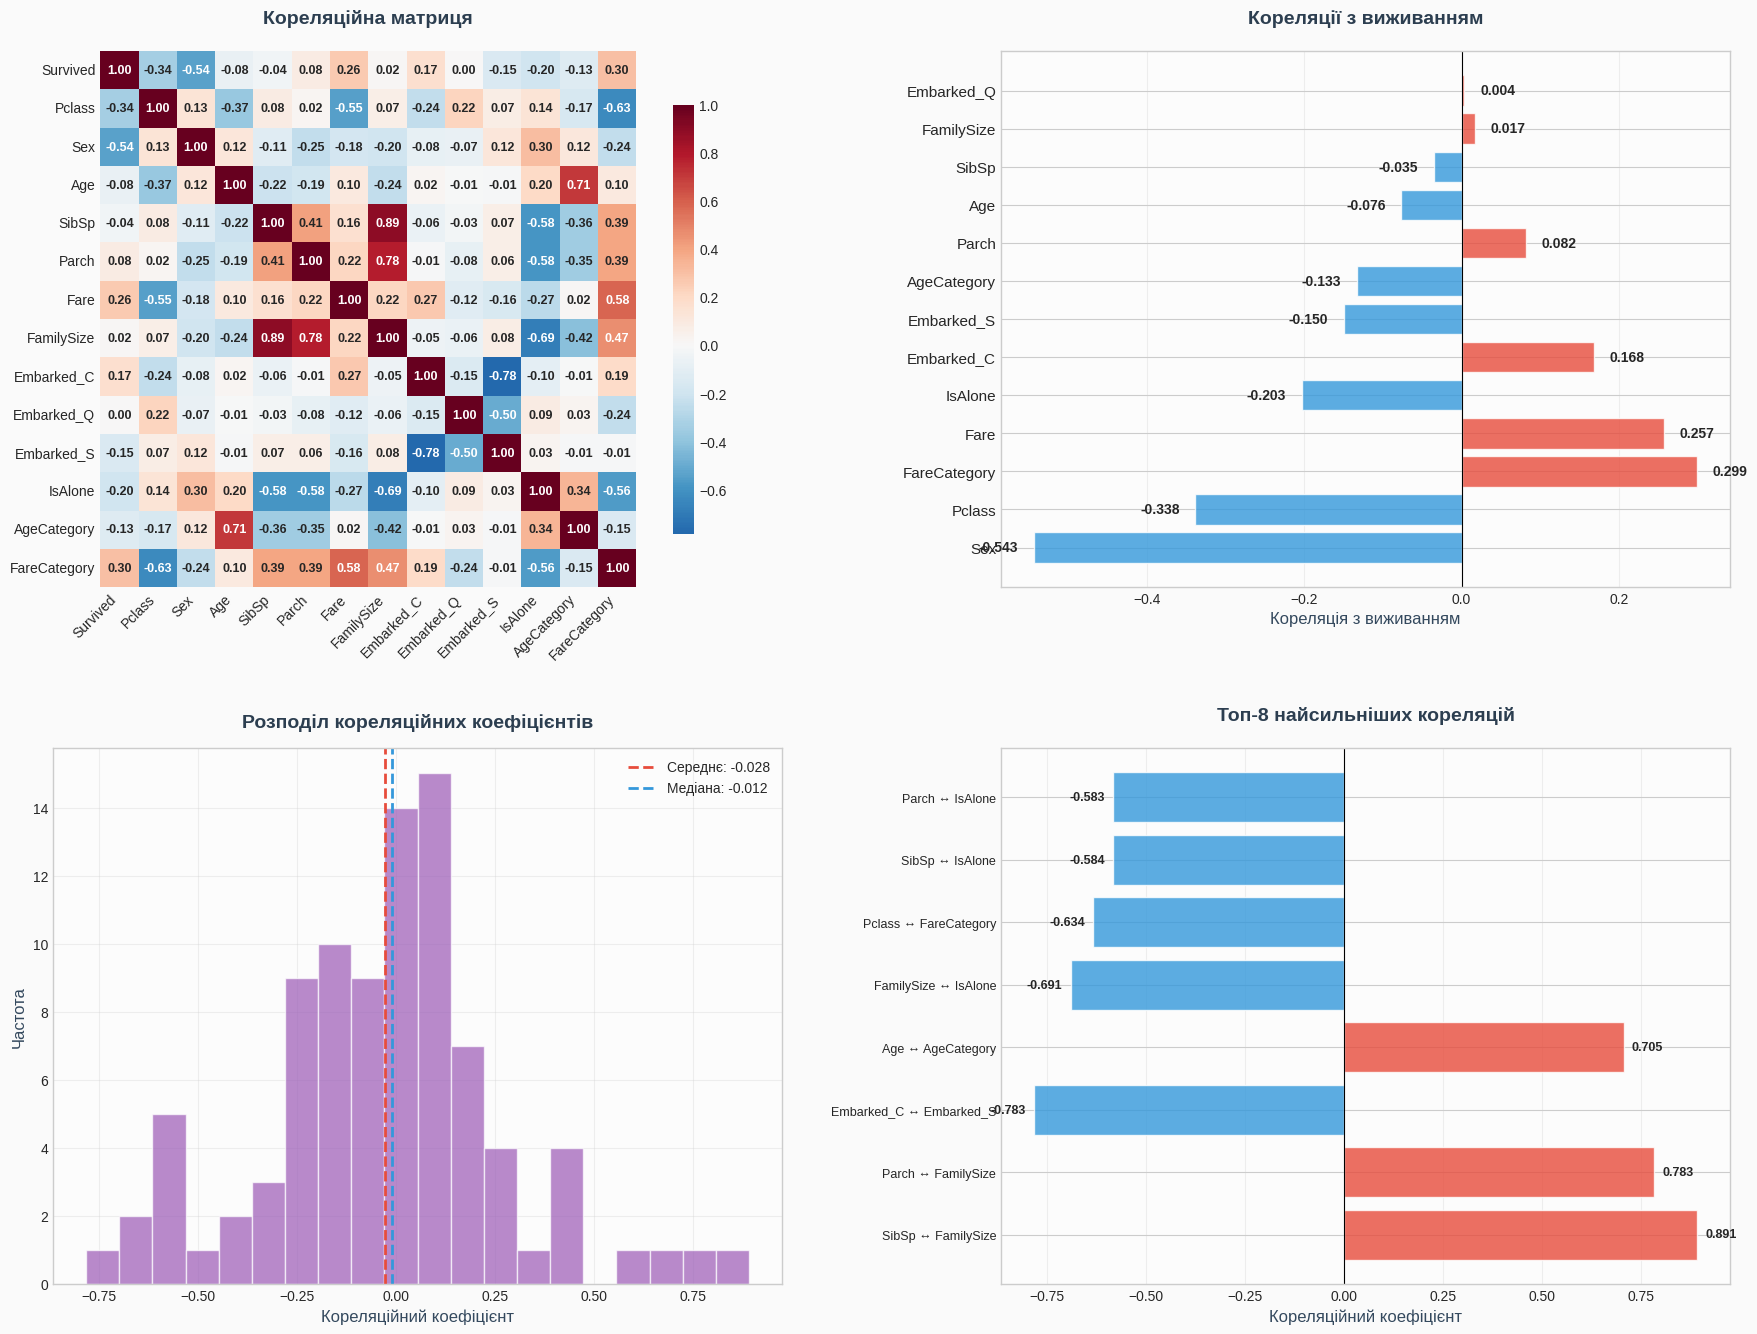


            КОРЕЛЯЦІЙНИЙ АНАЛІЗ - ВИСНОВКИ

📊 ОСНОВНІ КОРЕЛЯЦІЇ З ВИЖИВАННЯМ:
   • Sex: -0.543 (сильно негативно корелює)
   • Pclass: -0.338 (сильно негативно корелює)
   • FareCategory: 0.299 (помірно позитивно корелює)

🔍 НАЙСИЛЬНІШІ КОРЕЛЯЦІЇ В ДАТАСЕТІ:
   • SibSp - FamilySize: 0.891 (позитивна)
   • Parch - FamilySize: 0.783 (позитивна)
   • Embarked_C - Embarked_S: -0.783 (негативна)

📈 СТАТИСТИКА КОРЕЛЯЦІЙ:
   • Середнє значення: -0.028
   • Медіана: -0.012
   • Стандартне відхилення: 0.306
   • Кореляцій > 0.5: 12
   • Кореляцій > 0.3: 24



In [14]:
# Кореляційний аналіз Titanic датасету
plt.style.use('seaborn-v0_8-whitegrid')
df = df_final
# Кольорова схема для кореляції
CORR_COLORS = {
    'bg_main': '#FAFAFA',
    'bg_plot': '#FCFCFC',
    'text_main': '#2C3E50',
    'text_secondary': '#34495E',
    'positive': '#E74C3C',
    'negative': '#3498DB',
    'neutral': '#95A5A6'
}

# Створення фігури для кореляційного аналізу
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.patch.set_facecolor(CORR_COLORS['bg_main'])
# fig.suptitle('Кореляційний аналіз датасету Titanic',
#              fontsize=18, fontweight='600', color=CORR_COLORS['text_main'], y=0.95)

# Підготовка числових даних
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

# 1. Основна кореляційна матриця (повна)
axes[0,0].set_facecolor(CORR_COLORS['bg_plot'])

sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdBu_r',
            center=0,
            square=True,
            ax=axes[0,0],
            fmt='.2f',
            cbar_kws={"shrink": 0.8},
            annot_kws={'size': 9, 'weight': 'bold'})

axes[0,0].set_title('Кореляційна матриця',
                    fontsize=14, fontweight='600', color=CORR_COLORS['text_main'], pad=20)
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45, ha='right')
axes[0,0].set_yticklabels(axes[0,0].get_yticklabels(), rotation=0)

# 2. Кореляції з виживанням (окремо)
axes[0,1].set_facecolor(CORR_COLORS['bg_plot'])
survival_corrs = correlation_matrix['Survived'].drop('Survived').sort_values(key=abs, ascending=False)

colors = [CORR_COLORS['positive'] if x > 0 else CORR_COLORS['negative'] for x in survival_corrs.values]
bars = axes[0,1].barh(range(len(survival_corrs)), survival_corrs.values,
                      color=colors, alpha=0.8, edgecolor='white')

# Додавання значень на бари
for i, (bar, value) in enumerate(zip(bars, survival_corrs.values)):
    axes[0,1].text(value + (0.02 if value > 0 else -0.02), i,
                   f'{value:.3f}',
                   ha='left' if value > 0 else 'right',
                   va='center',
                   fontweight='bold',
                   fontsize=10)

axes[0,1].set_yticks(range(len(survival_corrs)))
axes[0,1].set_yticklabels(survival_corrs.index, fontsize=11)
axes[0,1].set_xlabel('Кореляція з виживанням', fontsize=12, color=CORR_COLORS['text_secondary'])
axes[0,1].set_title('Кореляції з виживанням', fontsize=14, fontweight='600',
                    color=CORR_COLORS['text_main'], pad=20)
axes[0,1].grid(True, alpha=0.3, axis='x')
axes[0,1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# 3. Розподіл кореляційних коефіцієнтів
axes[1,0].set_facecolor(CORR_COLORS['bg_plot'])
# Беремо всі кореляції окрім діагональних
corr_values = correlation_matrix.values
corr_flat = corr_values[np.triu_indices_from(corr_values, k=1)]

axes[1,0].hist(corr_flat, bins=20, alpha=0.7, color='#9B59B6', edgecolor='white')
axes[1,0].axvline(np.mean(corr_flat), color=CORR_COLORS['positive'],
                  linestyle='--', linewidth=2, label=f'Середнє: {np.mean(corr_flat):.3f}')
axes[1,0].axvline(np.median(corr_flat), color=CORR_COLORS['negative'],
                  linestyle='--', linewidth=2, label=f'Медіана: {np.median(corr_flat):.3f}')

axes[1,0].set_xlabel('Кореляційний коефіцієнт', fontsize=12, color=CORR_COLORS['text_secondary'])
axes[1,0].set_ylabel('Частота', fontsize=12, color=CORR_COLORS['text_secondary'])
axes[1,0].set_title('Розподіл кореляційних коефіцієнтів',
                    fontsize=14, fontweight='600', color=CORR_COLORS['text_main'], pad=15)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Топ-5 найсильніших кореляцій (за модулем)
axes[1,1].set_facecolor(CORR_COLORS['bg_plot'])

# Знаходимо найсильніші кореляції
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append({
            'pair': f'{correlation_matrix.columns[i]} - {correlation_matrix.columns[j]}',
            'correlation': correlation_matrix.iloc[i,j]
        })

# Сортуємо за абсолютним значенням
corr_df = pd.DataFrame(corr_pairs)
top_corrs = corr_df.reindex(corr_df['correlation'].abs().sort_values(ascending=False).index).head(8)

colors_top = [CORR_COLORS['positive'] if x > 0 else CORR_COLORS['negative']
              for x in top_corrs['correlation'].values]

bars = axes[1,1].barh(range(len(top_corrs)), top_corrs['correlation'].values,
                      color=colors_top, alpha=0.8, edgecolor='white')

# Додавання значень
for i, (bar, value) in enumerate(zip(bars, top_corrs['correlation'].values)):
    axes[1,1].text(value + (0.02 if value > 0 else -0.02), i,
                   f'{value:.3f}',
                   ha='left' if value > 0 else 'right',
                   va='center',
                   fontweight='bold',
                   fontsize=9)

axes[1,1].set_yticks(range(len(top_corrs)))
axes[1,1].set_yticklabels([pair.replace(' - ', ' ↔ ') for pair in top_corrs['pair']],
                          fontsize=9)
axes[1,1].set_xlabel('Кореляційний коефіцієнт', fontsize=12, color=CORR_COLORS['text_secondary'])
axes[1,1].set_title('Топ-8 найсильніших кореляцій',
                    fontsize=14, fontweight='600', color=CORR_COLORS['text_main'], pad=20)
axes[1,1].grid(True, alpha=0.3, axis='x')
axes[1,1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Фінальні налаштування
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)
plt.show()

# Текстовий аналіз кореляцій
print("\n" + "="*60)
print("            КОРЕЛЯЦІЙНИЙ АНАЛІЗ - ВИСНОВКИ")
print("="*60)

print(f"\n📊 ОСНОВНІ КОРЕЛЯЦІЇ З ВИЖИВАННЯМ:")
for feature, corr in survival_corrs.head(3).items():
    direction = "позитивно" if corr > 0 else "негативно"
    strength = "сильно" if abs(corr) > 0.3 else "помірно" if abs(corr) > 0.1 else "слабо"
    print(f"   • {feature}: {corr:.3f} ({strength} {direction} корелює)")

print(f"\n🔍 НАЙСИЛЬНІШІ КОРЕЛЯЦІЇ В ДАТАСЕТІ:")
for _, row in top_corrs.head(3).iterrows():
    direction = "позитивна" if row['correlation'] > 0 else "негативна"
    print(f"   • {row['pair']}: {row['correlation']:.3f} ({direction})")

print(f"\n📈 СТАТИСТИКА КОРЕЛЯЦІЙ:")
print(f"   • Середнє значення: {np.mean(corr_flat):.3f}")
print(f"   • Медіана: {np.median(corr_flat):.3f}")
print(f"   • Стандартне відхилення: {np.std(corr_flat):.3f}")
print(f"   • Кореляцій > 0.5: {sum(abs(x) > 0.5 for x in corr_flat)}")
print(f"   • Кореляцій > 0.3: {sum(abs(x) > 0.3 for x in corr_flat)}")

print("\n" + "="*60)

Уже можна побачити кілька цікавих змінних, які мають сильну кореляцію із цільовою змінною, але наразі ми не проводили ніяких трансформацій над датасетом, і у кореляційному аналізі упущенно зміну "стать", яка потенційно також сильну кореляцію із цільовою, топу приступимо до неї.

In [9]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


=== ПОКРОКОВА ТРАНСФОРМАЦІЯ ДАТАСЕТУ TITANIC ===
Початковий розмір: (891, 13)
Колонки: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize']

КРОК 1: ОЧИЩЕННЯ ТА ЗАПОВНЕННЯ ПРОПУЩЕНИХ ЗНАЧЕНЬ

--- Аналіз пропущених значень ---
  • Age: 177 (19.9%)
  • Cabin: 687 (77.1%)
  • Embarked: 2 (0.2%)

--- Видалення непотрібних колонок ---
Видалені колонки: ['PassengerId', 'Name', 'Ticket', 'Cabin']
Залишилось колонок: 9

--- Заповнення віку (Age) ---
Пропущених значень Age: 177
KNN Imputation використав 5 ознак для заповнення
Всього заповнено Age: 177 значень

--- Заповнення порту посадки (Embarked) ---
Заповнено 2 значень модою: S

--- Результат кроку 1 ---
Розмір після очищення: (891, 9)
Пропущені значення після обробки: 0
Колонки: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize']

КРОК 2: КОДУВАННЯ КАТЕГОРІАЛЬНИХ ЗМІННИХ

--- Аналіз категоріальних змінних ---
  • Sex: ['male' 

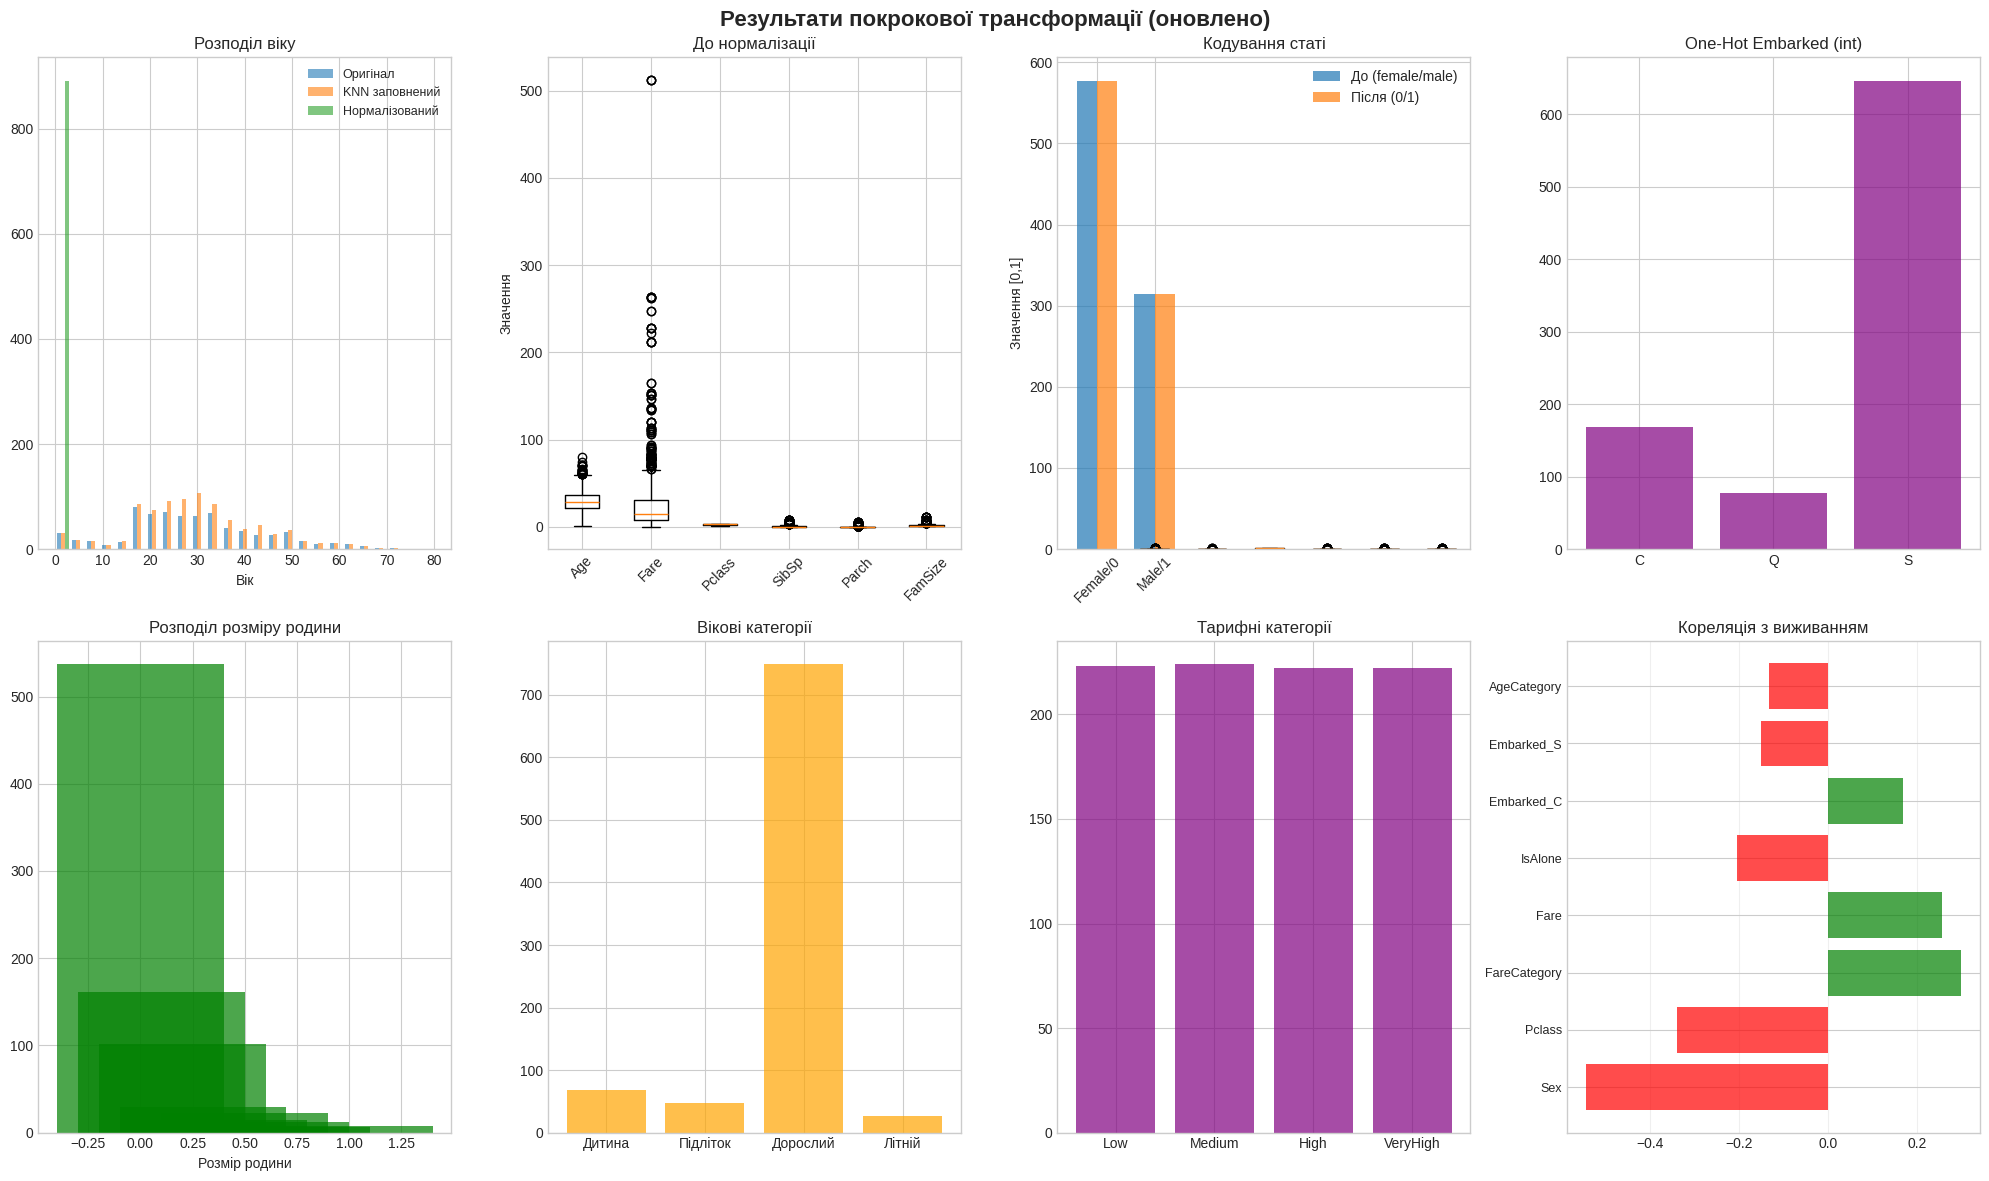


                      ФІНАЛЬНИЙ ЗВІТ

📊 ТРАНСФОРМАЦІЯ ЗАВЕРШЕНА:
   • Початковий розмір: (891, 13)
   • Фінальний розмір: (891, 14)
   • Пропущені значення: 866 → 0

🔧 ВИКОНАНІ КРОКИ:
   КРОК 1 - Очищення:
     • Видалено 4 колонки: PassengerId, Name, Ticket, Cabin
     • Заповнено 177 значень Age через KNN Imputation
     • Заповнено Embarked
   КРОК 2 - Кодування:
     • Sex: Label Encoding (female=0, male=1)
     • Embarked: One-Hot Encoding з int (0/1)
   КРОК 3 - Нові ознаки:
     • FamilySize, IsAlone, AgeCategory, FareCategory
   КРОК 4 - Нормалізація:
     • 6 числових ознак нормалізовані до [0, 1]
     • Бінарні та категоріальні ознаки залишені без змін

🎯 ГОТОВИЙ ДАТАСЕТ ДЛЯ PYTORCH:
   • Всі змінні числові (int/float)
   • Немає пропущених значень
   • 14 ознак для навчання
   • Числові ознаки: [0, 1] діапазон
   • One-hot змінні: int (0/1)
   • Категоріальні: дискретні значення
   • Природний розподіл після KNN імпутації

🚀 ГОТОВИЙ ДЛЯ:
   • PyTorch нейронні мережі
   • Sc

In [10]:
# Покрокова трансформація датасету Titanic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("=== ПОКРОКОВА ТРАНСФОРМАЦІЯ ДАТАСЕТУ TITANIC ===")
print(f"Початковий розмір: {df.shape}")
print(f"Колонки: {list(df.columns)}")

# ===== КРОК 1: ОЧИЩЕННЯ ТА ЗАПОВНЕННЯ ПРОПУЩЕНИХ ЗНАЧЕНЬ =====
print("\n" + "="*60)
print("КРОК 1: ОЧИЩЕННЯ ТА ЗАПОВНЕННЯ ПРОПУЩЕНИХ ЗНАЧЕНЬ")
print("="*60)

# Створюємо копію
df_step1 = df.copy()

print("\n--- Аналіз пропущених значень ---")
missing_info = []
for col in df_step1.columns:
    missing_count = df_step1[col].isnull().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(df_step1)) * 100
        missing_info.append(f"{col}: {missing_count} ({missing_pct:.1f}%)")

if missing_info:
    for info in missing_info:
        print(f"  • {info}")
else:
    print("  • Пропущених значень не знайдено")

# 1.1 Видалення непотрібних колонок
print("\n--- Видалення непотрібних колонок ---")
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_step1 = df_step1.drop(columns=columns_to_drop)
print(f"Видалені колонки: {columns_to_drop}")
print(f"Залишилось колонок: {df_step1.shape[1]}")

# 1.2 Заповнення Age
print("\n--- Заповнення віку (Age) ---")
age_missing_before = df_step1['Age'].isnull().sum()
print(f"Пропущених значень Age: {age_missing_before}")

# Використовуємо KNN Imputation для більш природного розподілу
from sklearn.impute import KNNImputer

# Підготовка даних для KNN (використовуємо числові ознаки)
features_for_imputation = ['Pclass', 'SibSp', 'Parch', 'Fare']
# Тимчасово кодуємо стать для KNN
sex_temp = LabelEncoder().fit_transform(df_step1['Sex'])

# Створюємо тимчасовий датасет для імпутації
temp_data = df_step1[features_for_imputation + ['Age']].copy()
temp_data['Sex_temp'] = sex_temp

# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
temp_data_filled = knn_imputer.fit_transform(temp_data)

# Повертаємо заповнені значення назад
df_step1['Age'] = temp_data_filled[:, -2]  # Age колонка
age_filled = age_missing_before

print(f"KNN Imputation використав {len(features_for_imputation)+1} ознак для заповнення")
print(f"Всього заповнено Age: {age_filled} значень")

# 1.3 Заповнення Embarked
print("\n--- Заповнення порту посадки (Embarked) ---")
embarked_missing = df_step1['Embarked'].isnull().sum()
if embarked_missing > 0:
    embarked_mode = df_step1['Embarked'].mode()[0]
    df_step1['Embarked'].fillna(embarked_mode, inplace=True)
    print(f"Заповнено {embarked_missing} значень модою: {embarked_mode}")
else:
    print("Пропущених значень немає")

# Перевірка результату
print("\n--- Результат кроку 1 ---")
remaining_missing = df_step1.isnull().sum().sum()
print(f"Розмір після очищення: {df_step1.shape}")
print(f"Пропущені значення після обробки: {remaining_missing}")
print(f"Колонки: {list(df_step1.columns)}")

# ===== КРОК 2: КОДУВАННЯ КАТЕГОРІАЛЬНИХ ЗМІННИХ =====
print("\n" + "="*60)
print("КРОК 2: КОДУВАННЯ КАТЕГОРІАЛЬНИХ ЗМІННИХ")
print("="*60)

df_step2 = df_step1.copy()

print("\n--- Аналіз категоріальних змінних ---")
categorical_cols = df_step2.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_values = df_step2[col].unique()
    print(f"  • {col}: {unique_values} ({len(unique_values)} значень)")

# 2.1 Кодування Sex (бінарна змінна)
print("\n--- Кодування статі (Sex) ---")
print("Стратегія: Label Encoding")
le_sex = LabelEncoder()
df_step2['Sex'] = le_sex.fit_transform(df_step2['Sex'])
sex_mapping = dict(zip(le_sex.classes_, le_sex.transform(le_sex.classes_)))
print(f"Маппінг: {sex_mapping}")

# 2.2 Кодування Embarked (номінальна змінна)
print("\n--- Кодування порту (Embarked) ---")
print("Стратегія: One-Hot Encoding з явним приведенням до int")
embarked_dummies = pd.get_dummies(df_step2['Embarked'], prefix='Embarked').astype(int)
df_step2 = df_step2.drop('Embarked', axis=1)
df_step2 = pd.concat([df_step2, embarked_dummies], axis=1)
print(f"Створені колонки: {list(embarked_dummies.columns)}")
print("One-hot змінні приведені до int (0/1) замість bool (True/False)")

# 2.3 Pclass залишаємо як є (порядкова змінна)
print("\n--- Клас (Pclass) ---")
print("Залишено як числова змінна (1, 2, 3) - має логічний порядок")

print("\n--- Результат кроку 2 ---")
print(f"Розмір: {df_step2.shape}")
print(f"Категоріальних колонок залишилось: {len(df_step2.select_dtypes(include=['object']).columns)}")
print(f"Всі колонки: {list(df_step2.columns)}")

# ===== КРОК 3: СТВОРЕННЯ НОВИХ ОЗНАК (FEATURE ENGINEERING) =====
print("\n" + "="*60)
print("КРОК 3: СТВОРЕННЯ НОВИХ ОЗНАК")
print("="*60)

df_step3 = df_step2.copy()

# 3.1 Розмір родини
print("\n--- Створення FamilySize ---")
df_step3['FamilySize'] = df_step3['SibSp'] + df_step3['Parch'] + 1
family_stats = df_step3['FamilySize'].value_counts().sort_index()
print("FamilySize = SibSp + Parch + 1")
print(f"Розподіл: {dict(family_stats.head())}")

# 3.2 Подорожує сам
print("\n--- Створення IsAlone ---")
df_step3['IsAlone'] = (df_step3['FamilySize'] == 1).astype(int)
alone_count = df_step3['IsAlone'].sum()
total_count = len(df_step3)
print(f"IsAlone: {alone_count} з {total_count} ({alone_count/total_count*100:.1f}%) подорожують самостійно")

# 3.3 Вікові категорії
print("\n--- Створення AgeCategory ---")
def categorize_age(age):
    if age < 12:
        return 0  # Дитина
    elif age < 18:
        return 1  # Підліток
    elif age < 60:
        return 2  # Дорослий
    else:
        return 3  # Літній

df_step3['AgeCategory'] = df_step3['Age'].apply(categorize_age)
age_cat_names = ['Дитина (<12)', 'Підліток (12-17)', 'Дорослий (18-59)', 'Літній (60+)']
age_distribution = df_step3['AgeCategory'].value_counts().sort_index()
for i, count in age_distribution.items():
    print(f"  {i} ({age_cat_names[i]}): {count} осіб")

# 3.4 Тарифні категорії
print("\n--- Створення FareCategory ---")
# Квартилі для тарифів
fare_quartiles = df_step3['Fare'].quantile([0.25, 0.5, 0.75]).values
print(f"Квартилі тарифів: {fare_quartiles}")

def categorize_fare(fare):
    if fare <= fare_quartiles[0]:
        return 0  # Low
    elif fare <= fare_quartiles[1]:
        return 1  # Medium
    elif fare <= fare_quartiles[2]:
        return 2  # High
    else:
        return 3  # VeryHigh

df_step3['FareCategory'] = df_step3['Fare'].apply(categorize_fare)
fare_cat_names = ['Low', 'Medium', 'High', 'VeryHigh']
fare_distribution = df_step3['FareCategory'].value_counts().sort_index()
for i, count in fare_distribution.items():
    print(f"  {i} ({fare_cat_names[i]}): {count} осіб")

print("\n--- Результат кроку 3 ---")
print(f"Фінальний розмір: {df_step3.shape}")
print(f"Нові ознаки: FamilySize, IsAlone, AgeCategory, FareCategory")
print(f"Всі колонки: {list(df_step3.columns)}")

# ===== КРОК 4: НОРМАЛІЗАЦІЯ ЧИСЛОВИХ ОЗНАК =====
print("\n" + "="*60)
print("КРОК 4: НОРМАЛІЗАЦІЯ ЧИСЛОВИХ ОЗНАК")
print("="*60)

df_step4 = df_step3.copy()

# 4.1 Ідентифікація числових ознак для нормалізації
print("\n--- Аналіз числових ознак ---")
# Нормалізуємо всі числові змінні окрім бінарних та категоріальних
numeric_cols_to_scale = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'FamilySize']
binary_cols = ['Survived', 'Sex', 'IsAlone'] + [col for col in df_step4.columns if col.startswith('Embarked_')]
categorical_cols = ['AgeCategory', 'FareCategory']

print(f"Ознаки для нормалізації: {numeric_cols_to_scale}")
print(f"Бінарні (залишені 0/1): {binary_cols}")
print(f"Категоріальні (залишені як є): {categorical_cols}")

# Показуємо діапазони до нормалізації
print("\nДіапазони до нормалізації:")
for col in numeric_cols_to_scale:
    min_val, max_val = df_step4[col].min(), df_step4[col].max()
    print(f"  {col}: [{min_val:.2f}, {max_val:.2f}]")

# 4.2 MinMax нормалізація
print("\n--- MinMax нормалізація (0-1) ---")
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_step4[numeric_cols_to_scale] = scaler.fit_transform(df_step4[numeric_cols_to_scale])

# Показуємо діапазони після нормалізації
print("Діапазони після нормалізації:")
for col in numeric_cols_to_scale:
    min_val, max_val = df_step4[col].min(), df_step4[col].max()
    print(f"  {col}: [{min_val:.3f}, {max_val:.3f}]")

print("\n--- Результат кроку 4 ---")
print(f"Нормалізовано ознак: {len(numeric_cols_to_scale)}")
print("Всі числові ознаки в діапазоні [0, 1]")
print("Бінарні та категоріальні ознаки залишені без змін")

# ===== ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ =====
print("\n--- Візуалізація трансформацій ---")

fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Результати покрокової трансформації (оновлено)', fontsize=16, fontweight='bold')

# 1. Розподіл віку (оригінал vs KNN vs нормалізований)
axes[0,0].hist([df['Age'].dropna(), df_step3['Age'], df_step4['Age']],
               bins=25, alpha=0.6, label=['Оригінал', 'KNN заповнений', 'Нормалізований'])
axes[0,0].set_title('Розподіл віку')
axes[0,0].set_xlabel('Вік')
axes[0,0].legend(fontsize=9)

# 2. Нормалізація числових ознак (до/після)
axes[0,1].boxplot([df_step3[col] for col in numeric_cols_to_scale],
                  labels=[col.replace('Family', 'Fam') for col in numeric_cols_to_scale])
axes[0,1].set_title('До нормалізації')
axes[0,1].set_ylabel('Значення')
axes[0,1].tick_params(axis='x', rotation=45)

axes[0,2].boxplot([df_step4[col] for col in numeric_cols_to_scale],
                  labels=[col.replace('Family', 'Fam') for col in numeric_cols_to_scale])
axes[0,2].set_title('Після нормалізації')
axes[0,2].set_ylabel('Значення [0,1]')
axes[0,2].tick_params(axis='x', rotation=45)

# 3. Кодування статі
sex_before = df['Sex'].value_counts()
sex_after = df_step4['Sex'].value_counts()
x = range(2)
width = 0.35
axes[0,2].bar([i - width/2 for i in x], sex_before.values, width, label='До (female/male)', alpha=0.7)
axes[0,2].bar([i + width/2 for i in x], sex_after.values, width, label='Після (0/1)', alpha=0.7)
axes[0,2].set_title('Кодування статі')
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(['Female/0', 'Male/1'])
axes[0,2].legend()

# 4. One-hot encoding перевірка
embarked_cols = [col for col in df_step4.columns if col.startswith('Embarked_')]
embarked_sum = df_step4[embarked_cols].sum()
axes[0,3].bar(embarked_sum.index, embarked_sum.values, alpha=0.7, color='purple')
axes[0,3].set_title('One-Hot Embarked (int)')
axes[0,3].set_xticklabels([col.replace('Embarked_', '') for col in embarked_cols])

# 5. Розмір родини
family_dist = df_step4['FamilySize'].value_counts().sort_index()
axes[1,0].bar(family_dist.index, family_dist.values, alpha=0.7, color='green')
axes[1,0].set_title('Розподіл розміру родини')
axes[1,0].set_xlabel('Розмір родини')

# 6. Вікові категорії
age_dist = df_step4['AgeCategory'].value_counts().sort_index()
axes[1,1].bar(age_dist.index, age_dist.values, alpha=0.7, color='orange')
axes[1,1].set_title('Вікові категорії')
axes[1,1].set_xticks(age_dist.index)
axes[1,1].set_xticklabels([name.split(' ')[0] for name in age_cat_names])

# 7. Тарифні категорії
fare_dist = df_step4['FareCategory'].value_counts().sort_index()
axes[1,2].bar(fare_dist.index, fare_dist.values, alpha=0.7, color='purple')
axes[1,2].set_title('Тарифні категорії')
axes[1,2].set_xticks(fare_dist.index)
axes[1,2].set_xticklabels(fare_cat_names)

# 8. Кореляція з виживанням (фінальна)
numeric_cols = df_step4.select_dtypes(include=[np.number]).columns
corr_with_survival = df_step4[numeric_cols].corr()['Survived'].drop('Survived').sort_values(key=abs, ascending=False)
top_corr = corr_with_survival.head(8)

colors = ['red' if x < 0 else 'green' for x in top_corr.values]
axes[1,3].barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
axes[1,3].set_title('Кореляція з виживанням')
axes[1,3].set_yticks(range(len(top_corr)))
axes[1,3].set_yticklabels(top_corr.index, fontsize=9)
axes[1,3].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ===== ФІНАЛЬНИЙ ЗВІТ =====
print("\n" + "="*70)
print("                      ФІНАЛЬНИЙ ЗВІТ")
print("="*70)

print(f"\n📊 ТРАНСФОРМАЦІЯ ЗАВЕРШЕНА:")
print(f"   • Початковий розмір: {df.shape}")
print(f"   • Фінальний розмір: {df_step4.shape}")
print(f"   • Пропущені значення: {df.isnull().sum().sum()} → {df_step4.isnull().sum().sum()}")

print(f"\n🔧 ВИКОНАНІ КРОКИ:")
print(f"   КРОК 1 - Очищення:")
print(f"     • Видалено 4 колонки: PassengerId, Name, Ticket, Cabin")
print(f"     • Заповнено {age_filled} значень Age через KNN Imputation")
print(f"     • Заповнено Embarked")
print(f"   КРОК 2 - Кодування:")
print(f"     • Sex: Label Encoding (female=0, male=1)")
print(f"     • Embarked: One-Hot Encoding з int (0/1)")
print(f"   КРОК 3 - Нові ознаки:")
print(f"     • FamilySize, IsAlone, AgeCategory, FareCategory")
print(f"   КРОК 4 - Нормалізація:")
print(f"     • {len(numeric_cols_to_scale)} числових ознак нормалізовані до [0, 1]")
print(f"     • Бінарні та категоріальні ознаки залишені без змін")

print(f"\n🎯 ГОТОВИЙ ДАТАСЕТ ДЛЯ PYTORCH:")
print(f"   • Всі змінні числові (int/float)")
print(f"   • Немає пропущених значень")
print(f"   • {df_step4.shape[1]} ознак для навчання")
print(f"   • Числові ознаки: [0, 1] діапазон")
print(f"   • One-hot змінні: int (0/1)")
print(f"   • Категоріальні: дискретні значення")
print(f"   • Природний розподіл після KNN імпутації")

print("\n🚀 ГОТОВИЙ ДЛЯ:")
print("   • PyTorch нейронні мережі")
print("   • Scikit-learn алгоритми")
print("   • Будь-які ML pipeline")

print("\n" + "="*70)

# Зберігаємо результат
df_final = df_step4
print(f"Фінальний датасет збережений як df_final: {df_final.shape}")

In [11]:
df_final.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S,IsAlone,AgeCategory,FareCategory
0,0,1.0,1,0.271174,0.125,0.000000,0.014151,0.1,0,0,1,0,2,0
1,1,0.0,0,0.472229,0.125,0.000000,0.139136,0.1,1,0,0,0,2,3
2,1,1.0,0,0.321438,0.000,0.000000,0.015469,0.0,0,0,1,1,2,1
3,1,0.0,0,0.434531,0.125,0.000000,0.103644,0.1,0,0,1,0,2,3
4,0,1.0,1,0.434531,0.000,0.000000,0.015713,0.0,0,0,1,1,2,1
5,0,1.0,1,0.323951,0.000,0.000000,0.016510,0.0,0,1,0,1,2,1
6,0,0.0,1,0.673285,0.000,0.000000,0.101229,0.0,0,0,1,1,2,3
7,0,1.0,1,0.019854,0.375,0.166667,0.041136,0.4,0,0,1,0,0,2
8,1,1.0,0,0.334004,0.000,0.333333,0.021731,0.2,0,0,1,0,2,1
9,1,0.5,0,0.170646,0.125,0.000000,0.058694,0.1,1,0,0,0,1,2


були виконані такі дії:

In [12]:
нова кореляція

SyntaxError: invalid syntax (ipython-input-669328238.py, line 1)